In [49]:
# from google.colab import drive
# drive.mount('/content/drive')
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn_evaluation.plot import grid_search
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity

import statsmodels.api as sm  # For fitting statistical models
import statsmodels.formula.api as smf  # For fitting statistical models using formulas

from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imPipeline



In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Crimes_2022.csv')

In [60]:
try:
    df = pd.read_pickle('Data/Chicago_crime_2022_cleaned.pickle')
except:
    df = pd.read_json('Chicago_crime_2022_cleaned.json')

In [61]:
df.head()

,Date,IUCR,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Latitude,Longitude
2,2022-08-14 14:00:00,1562,AGGRAVATED CRIMINAL SEXUAL ABUSE,RESIDENCE,0,0,1621,16,39.0,11,17,41.985875,-87.766404
5,2022-02-19 10:36:00,486,DOMESTIC BATTERY SIMPLE,HOSPITAL BUILDING / GROUNDS,1,1,1211,12,26.0,24,8,41.900506,-87.699285
12,2022-09-16 07:00:00,320,STRONG ARM - NO WEAPON,APARTMENT,0,0,1411,14,35.0,21,3,41.935972,-87.703859
13,2022-10-30 05:30:00,326,AGGRAVATED VEHICULAR HIJACKING,STREET,0,0,113,1,34.0,32,3,41.878224,-87.627131
14,2022-11-05 12:49:00,620,UNLAWFUL ENTRY,WAREHOUSE,1,0,1111,11,37.0,23,5,41.896112,-87.737267


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78084 entries, 2 to 239598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  78084 non-null  datetime64[ns]
 1   IUCR                  78084 non-null  int64         
 2   Description           78084 non-null  object        
 3   Location Description  78084 non-null  object        
 4   Arrest                78084 non-null  int64         
 5   Domestic              78084 non-null  int64         
 6   Beat                  78084 non-null  int64         
 7   District              78084 non-null  int64         
 8   Ward                  78084 non-null  int64         
 9   Community Area        78084 non-null  int64         
 10  FBI Code              78084 non-null  int64         
 11  Latitude              78084 non-null  float64       
 12  Longitude             78084 non-null  float64       
dtypes: datetime64[ns](1)

In [22]:
df.shape

(78084, 13)

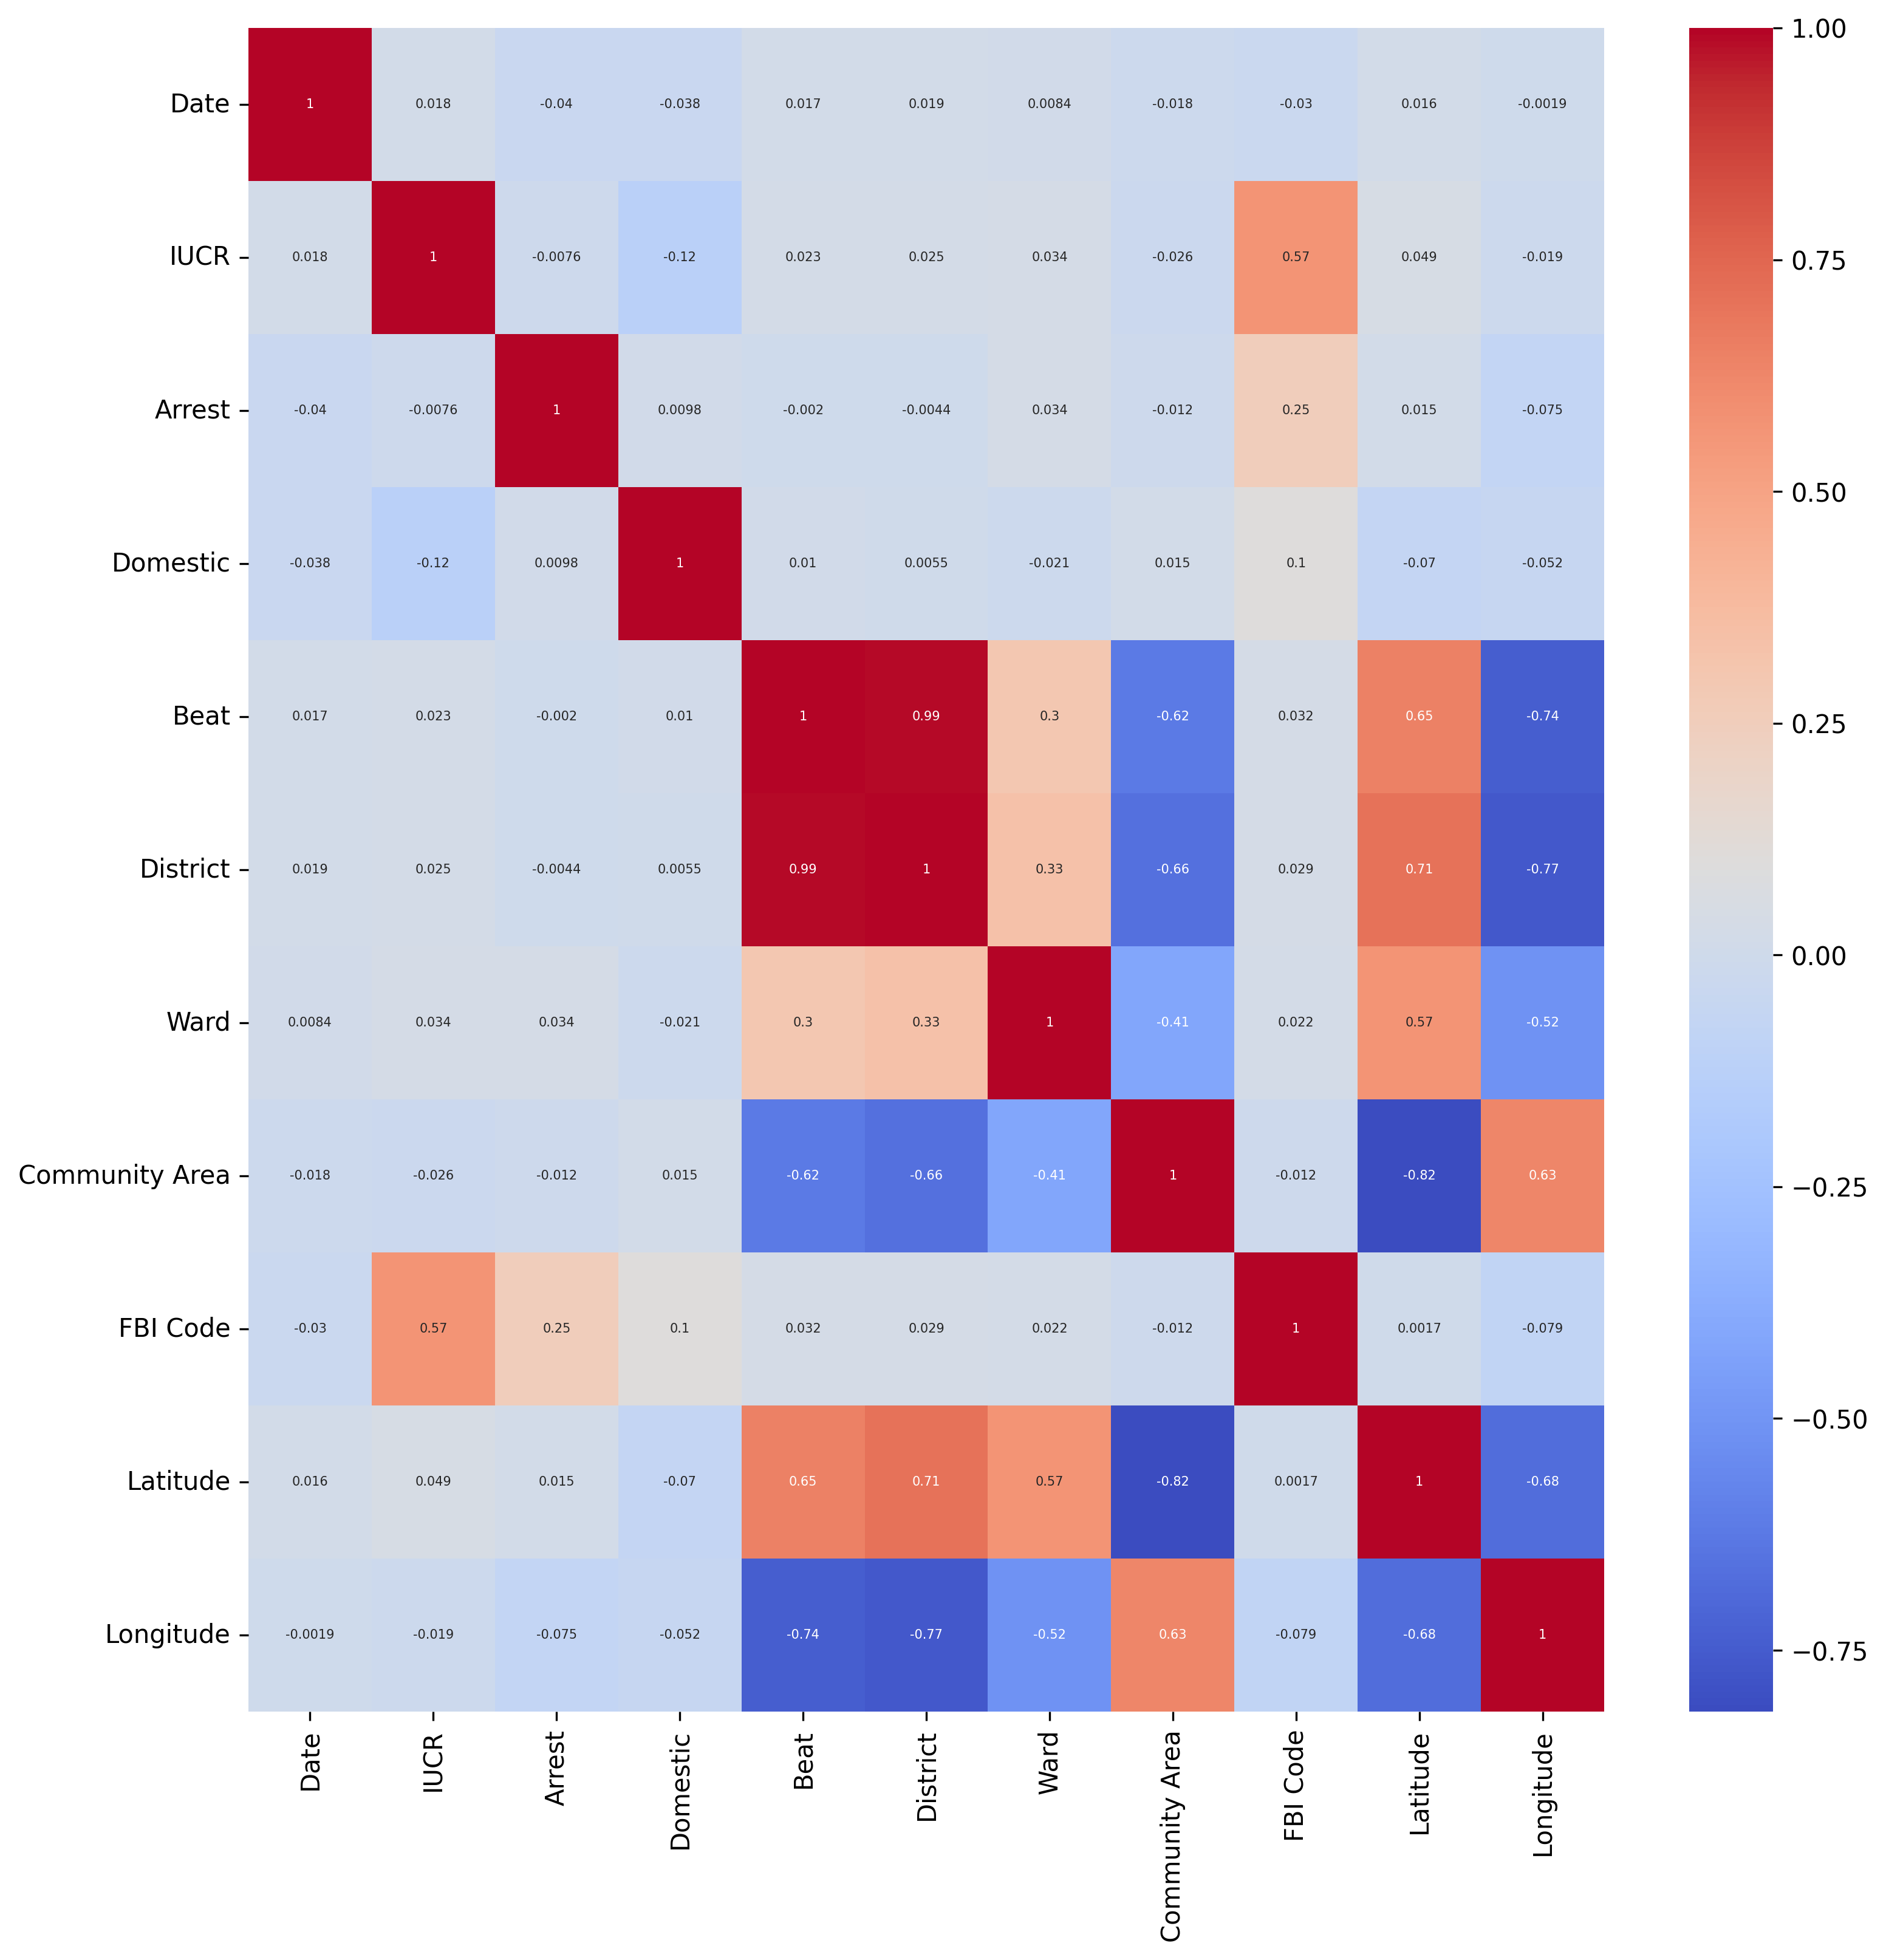

In [23]:
cat_cols = list(df.select_dtypes(include='object').columns)
plt.figure(figsize=(12,12),dpi=300)
corr = df.drop(columns=cat_cols).corr(method = 'spearman')
sns.heatmap(corr, cmap ='coolwarm',fmt='.2g',annot=True, annot_kws={"size":5}, xticklabels=1, yticklabels=1)
plt.savefig('SpearmanCorrHeat.jpg', format='jpeg', dpi=300, bbox_inches ='tight')

# Data Split & Preprocessing

In [24]:
X = df.drop(columns=['Arrest'])
y = df['Arrest']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [25]:
num_cols = list(X_train.select_dtypes(include=np.number).columns)
cat_cols = list(X_train.select_dtypes(include='object').columns)

In [10]:
print(num_cols)
print(cat_cols)

['IUCR', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code', 'Latitude', 'Longitude']
['Description', 'Location Description']


In [ ]:
ct = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('desc', TargetEncoder(), ['Description', 'Location Description']),
    # ('loc_desc',OneHotEncoder(handle_unknown='ignore'), ['Location Description'])
])

In [51]:
rf = RandomForestClassifier()
pipe_rf = Pipeline([
    ('ct', ct),
    ('clf', rf)

])
param_grid_rf = [{'clf':[rf], 'clf__max_depth': [2,4,6], 'clf__n_estimators': [200,500,1000]}]

np.random.seed(7)
gridSearch_rf = GridSearchCV(pipe_rf, param_grid=param_grid_rf, scoring='r2', n_jobs=-1, cv=StratifiedKFold(n_splits=5))
gridSearch_rf.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['IUCR',
                                                                          'Domestic',
                                                                          'Beat',
                                                                          'District',
                                                                          'Ward',
                                                                          'Community '
                                                                          'Area',
                                                                          'FBI '
                                                                          'Code',
                                                                          'Latitude',
                                                                          'Longitude']),
                                                                        ('desc',
                                                                         TargetEncoder(),
                                                                         ['Description',
                                                                          'Location '
                                                                          'Description'])])),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'clf': [RandomForestClassifier()],
                          'clf__max_depth': [2, 4, 6],
                          'clf__n_estimators': [200, 500, 1000]}],
             scoring='r2')

<Axes: title={'center': 'Grid search results'}, xlabel='clf__n_estimators', ylabel='Mean score'>

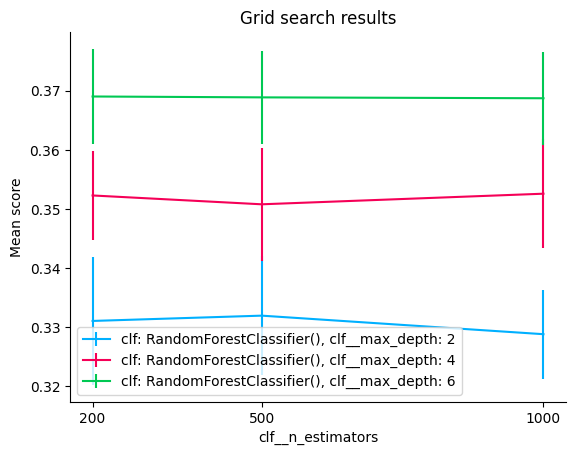

In [39]:
fig = plt.figure
grid_search(gridSearch_rf.cv_results_, change='clf__n_estimators')

In [58]:
# Save the model to disk
joblib.dump(gridSearch_rf, 'Data/gridSearch_rf.pickle')

# Load the model from disk when needed
# loaded_model = joblib.load('model_cache.pkl')


['Data/gridSearch_rf.pickle']

In [47]:
rf_balanced = RandomForestClassifier(class_weight='balanced')
pipe_rf_balanced = Pipeline([
    ('ct', ct),
    ('clf', rf_balanced)

])
param_grid_rf_balanced = [{'clf':[rf_balanced], 'clf__max_depth': [2,4,6], 'clf__n_estimators': [200,500,1000]}]

np.random.seed(7)
gridSearch_rf_balanced = GridSearchCV(pipe_rf_balanced, param_grid=param_grid_rf_balanced, n_jobs=-1, cv=StratifiedKFold(n_splits=5))
gridSearch_rf_balanced.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['IUCR',
                                                                          'Domestic',
                                                                          'Beat',
                                                                          'District',
                                                                          'Ward',
                                                                          'Community '
                                                                          'Area',
                                                                          'FBI '
                                                                          'Code',
                                                                          'Latitude',
                                                                          'Longitude']),
                                                                        ('desc',
                                                                         TargetEncoder(),
                                                                         ['Description',
                                                                          'Location '
                                                                          'Description'])])),
                                       ('clf',
                                        RandomForestClassifier(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid=[{'clf': [RandomForestClassifier(class_weight='balanced')],
                          'clf__max_depth': [2, 4, 6],
                          'clf__n_estimators': [200, 500, 1000]}])

In [59]:
joblib.dump(gridSearch_rf_balanced, 'Data/gridSearch_rf_balanced.pickle')


['Data/gridSearch_rf_balanced.pickle']

In [52]:

rf_imbalanced = RandomForestClassifier(class_weight='balanced')
pipe_rf_imbalanced = imPipeline([
    ('ct', ct),
    ('over', SMOTE() ),
    ('under', RandomUnderSampler() ),
    ('clf', rf_imbalanced)

])


param_grid_rf_imbalanced = [{'clf':[rf_imbalanced], 'clf__max_depth': [2,4,6], 'clf__n_estimators': [200,500,1000]}]

np.random.seed(7)
gridSearch_rf_imbalanced = GridSearchCV(pipe_rf_imbalanced, param_grid=param_grid_rf_imbalanced, n_jobs=-1, cv=StratifiedKFold(n_splits=5))
gridSearch_rf_imbalanced.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['IUCR',
                                                                          'Domestic',
                                                                          'Beat',
                                                                          'District',
                                                                          'Ward',
                                                                          'Community '
                                                                          'Area',
                                                                          'FBI '
                                                                          'Code',
                                                                          'Latitude',
                                                                          'Longitude']),
                                                                        ('desc',
                                                                         TargetEncoder(),
                                                                         ['Description',
                                                                          'Location '
                                                                          'Description'])])),
                                       ('over', SMOTE()),
                                       ('under', RandomUnderSampler()),
                                       ('clf',
                                        RandomForestClassifier(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid=[{'clf': [RandomForestClassifier(class_weight='balanced')],
                          'clf__max_depth': [2, 4, 6],
                          'clf__n_estimators': [200, 500, 1000]}])

In [57]:
joblib.dump(gridSearch_rf_imbalanced, 'Data/gridSearch_rf_imbalanced.pickle')


['Data/gridSearch_rf_imbalanced.pickle']

In [56]:
X_test.to_pickle('Data/X_test.pickle')
X_train.to_pickle('Data/X_train.pickle')
y_test.to_pickle('Data/y_test.pickle')
y_train.to_pickle('Data/y_train.pickle')